**1. ETC Analysis Task:** Using Data to Improve ETF Trading Decisions

**The Problem:**
When investing in Exchange-Traded Funds (ETFs), it’s important to know when to buy and sell to maximize profits. Many traders rely on past trends or intuition, but using data-driven methods like moving averages and forecasting can lead to better decision-making.

**What We’re Trying to Do:**
1️⃣ Understand Past Trends – We’ll collect 5+ years of ETF stock data using PySpark and yfinance.
2️⃣ Find Buy/Sell Signals – By calculating 10-day and 100-day moving averages, we can spot the best times to buy or sell.
3️⃣ Visualize the Market – Graphs will help us see how prices change over time and where trading opportunities exist.
4️⃣ Check If the Strategy Works – We’ll count buy and sell signals and see if they align with real market movements.
5️⃣ Predict Future Prices – Using Prophet, we’ll try to forecast ETF prices for the next 90 days to help traders plan ahead.

**The Goal:** Use data analysis to give traders clear insights and help them make smarter ETF investment decisions.


***2. Download Historical Data***

In [1]:
import yfinance as yf
import pandas as pd

# Define the ETF ticker symbol
etf_ticker = "SPY"

# Fetch 5 years of historical stock data
data = yf.download(etf_ticker, period="5y")

# Reset index to move the Date from index to a column
data.reset_index(inplace=True)

# Keep only relevant columns
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Save the cleaned dataset to a CSV file
data.to_csv("etf_data.csv", index=False)

# Display the first few rows
print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price        Date        Open        High         Low       Close     Volume
Ticker                    SPY         SPY         SPY         SPY        SPY
0      2020-03-05  282.754463  285.990119  278.146653  280.418091  186366800
1      2020-03-06  271.786446  277.006159  269.079259  275.782349  228667200
2      2020-03-09  255.237332  263.479482  253.522175  254.245331  309417300
3      2020-03-10  263.896686  267.493904  253.568507  267.401215  276444100
4      2020-03-11  260.243870  261.393495  251.139500  254.365875  255316300


***Load Data into PySpark***

In [2]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("ETF Analysis").getOrCreate()

# Load the CSV file into a PySpark DataFrame
df = spark.read.csv("etf_data.csv", header=True, inferSchema=True)

# Show the first few rows of data
df.show(5)


+----------+------------------+-----------------+------------------+------------------+---------+
|      Date|              Open|             High|               Low|             Close|   Volume|
+----------+------------------+-----------------+------------------+------------------+---------+
|      NULL|               SPY|              SPY|               SPY|               SPY|      SPY|
|2020-03-05| 282.7544628554482|285.9901185658013|278.14665258943756| 280.4180908203125|186366800|
|2020-03-06| 271.7864457098805|277.0061593318743| 269.0792589685934| 275.7823486328125|228667200|
|2020-03-09|255.23733240142136|263.4794817820567|253.52217492049354|254.24533081054688|309417300|
|2020-03-10|263.89668572605297|267.4939043987404|253.56850699723532| 267.4012145996094|276444100|
+----------+------------------+-----------------+------------------+------------------+---------+
only showing top 5 rows



***3. Calculate Moving Averages & Generate Trading Signals***

In [3]:
# Define moving average window sizes
short_window = 10   # Short-term (e.g., 10 days)
long_window = 100   # Long-term (e.g., 100 days)

# Compute moving averages
data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
data['Long_MA'] = data['Close'].rolling(window=long_window).mean()


***4. Create Buy & Sell Signals***

In [4]:
import numpy as np

# Generate trading signals:
# 1 (Buy) → Short-term MA crosses above Long-term MA
# -1 (Sell) → Short-term MA crosses below Long-term MA
# 0 (No Action) → Otherwise

data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1,
                 np.where(data['Short_MA'] < data['Long_MA'], -1, 0))

# Count total buy and sell signals
buy_signals = (data['Signal'] == 1).sum()
sell_signals = (data['Signal'] == -1).sum()

print(f"Buy Signals: {buy_signals}, Sell Signals: {sell_signals}")


Buy Signals: 921, Sell Signals: 236


***5. Visualizing Trends***

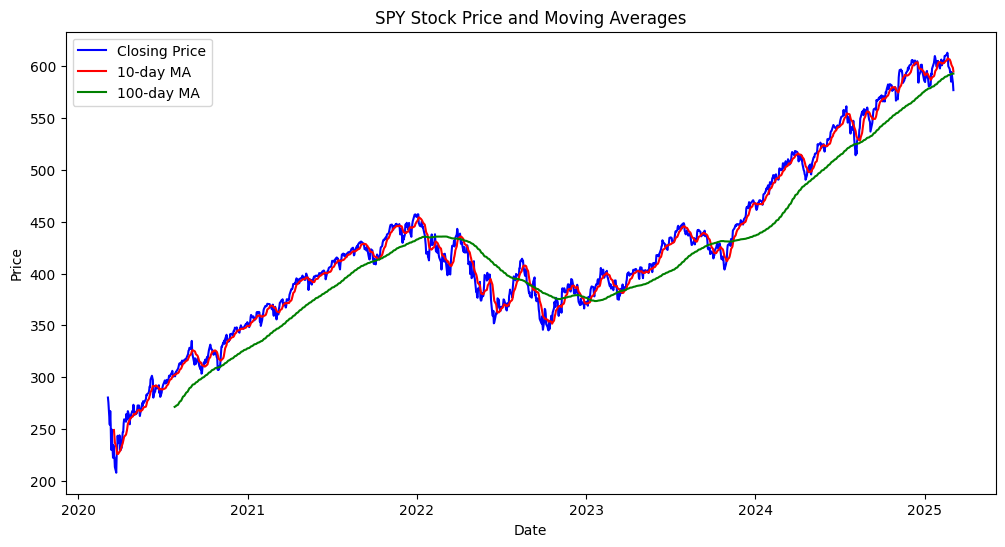

In [5]:
import matplotlib.pyplot as plt

# Plot the stock price along with moving averages
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label='Closing Price', color='blue')
plt.plot(data['Date'], data['Short_MA'], label=f'{short_window}-day MA', color='red')
plt.plot(data['Date'], data['Long_MA'], label=f'{long_window}-day MA', color='green')

plt.legend()
plt.title(f"{etf_ticker} Stock Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


**SECTION 2**


**1. Predicting ETF Prices for Smarter Investing**

**The Problem:**

When investing in Exchange-Traded Funds (ETFs), knowing what might happen next is crucial. Many investors rely on gut feelings or past trends, but this isn’t always reliable. Instead, using forecasting techniques, we can analyze historical price patterns and make better predictions about where the market is headed. This helps traders decide when to buy, sell, or hold for maximum profit.

**What We Plan to Do:**

1️⃣ Gather ETF Price Data – We’ll collect at least five years of stock prices to understand past trends.
2️⃣ Train a Forecasting Model – Using advanced tools, we’ll study seasonal trends and market patterns.
3️⃣ Make Future Predictions – Our model will estimate how ETF prices will move over the next 90 days.
4️⃣ Check If Our Predictions Are Accurate – We’ll compare our forecasted prices with actual stock prices to see how close we get.
5️⃣ Create Easy-to-Read Charts – We’ll generate clear visuals to help investors quickly understand what’s happening in the market.

**Why This Matters:**

Instead of making random guesses, we’re using real data to forecast future prices. This means investors can make smarter choices, reduce risks, and increase their chances of making a profit.

***2. Forecasting Future Prices Using Prophet***

In [6]:
from prophet import Prophet

# Prepare dataset
prophet_df = data[['Date', 'Close']]
prophet_df.columns = ['ds', 'y']


***3. Train the Forecasting Model***

In [7]:
# Initialize the Prophet model with yearly and weekly seasonality
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(prophet_df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp04zo8l1e/a23kqve2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp04zo8l1e/oz8xa__3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23033', 'data', 'file=/tmp/tmp04zo8l1e/a23kqve2.json', 'init=/tmp/tmp04zo8l1e/oz8xa__3.json', 'output', 'file=/tmp/tmp04zo8l1e/prophet_modelr6pp6wrb/prophet_model-20250304234946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:49:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:49:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Save Model**

In [8]:
import pickle

# Save the trained Prophet model
with open("prophet_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

print("Prophet model has been saved successfully!")


Prophet model has been saved successfully!


***4. Make Predictions for next 90 days***

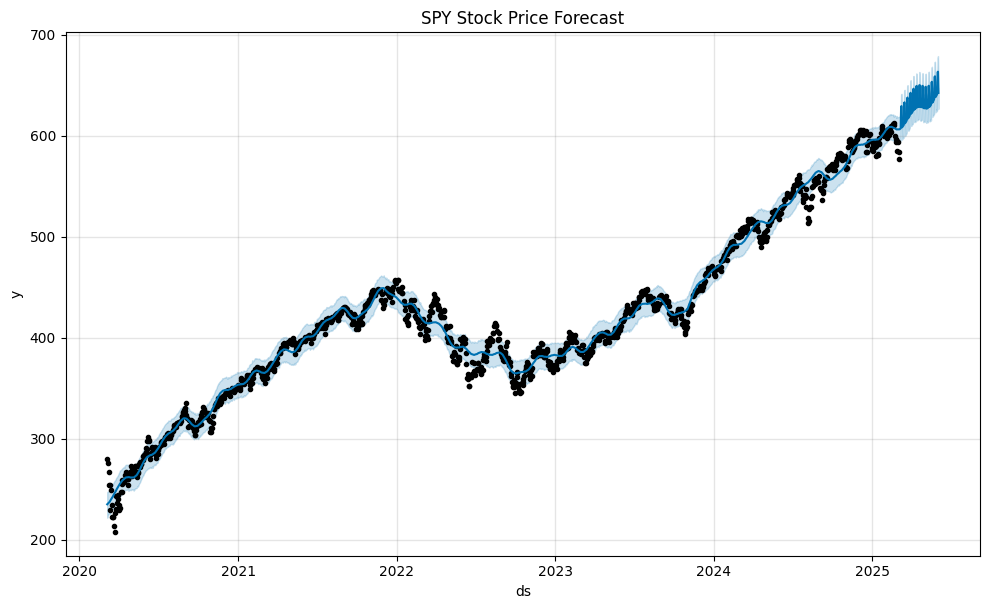

In [9]:
# Create a future dataframe for the next 90 days
future = model.make_future_dataframe(periods=90)

# Generate forecast
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title(f"{etf_ticker} Stock Price Forecast")
plt.show()


***5. Evaluate Forecast Accuracy***

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Select actual vs forecasted values
actual = prophet_df.set_index("ds")["y"].tail(90)
predicted = forecast.set_index("ds")["yhat"].tail(90)

# Calculate error metrics
mae = mean_absolute_error(actual, predicted)
# Calculate RMSE without 'squared' parameter,
# as it was not available in older versions and is now default behavior
rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f"MAE: {mae}, RMSE: {rmse}")



MAE: 36.89789712327755, RMSE: 39.20333758626254


**6. Visalize historical prices, forcasted prices, and interval of forecast.**

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp04zo8l1e/8jxwq9a5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp04zo8l1e/l6hvmmqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24209', 'data', 'file=/tmp/tmp04zo8l1e/8jxwq9a5.json', 'init=/tmp/tmp04zo8l1e/l6hvmmqo.json', 'output', 'file=/tmp/tmp04zo8l1e/prophet_model6q79nbu_/prophet_model-20250304235000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:50:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:50:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-03-05  248.903515  222.500735  247.696936   248.903515   248.903515   
1 2020-03-06  249.316374  223.320349  247.772161   249.316374   249.316374   
2 2020-03-09  250.554953  224.946789  249.646831   250.554953   250.554953   
3 2020-03-10  250.967813  225.772280  248.803980   250.967813   250.967813   
4 2020-03-11  251.380672  226.114061  250.781969   251.380672   251.380672   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0      -13.369799            -13.369799            -13.369799 -6.000278   
1      -13.329148            -13.329148            -13.329148 -5.899947   
2      -13.402767            -13.402767            -13.402767 -6.088619   
3      -13.346053            -13.346053            -13.346053 -6.160538   
4      -13.138332            -13.138332            -13.138332 -6.121652   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -6.

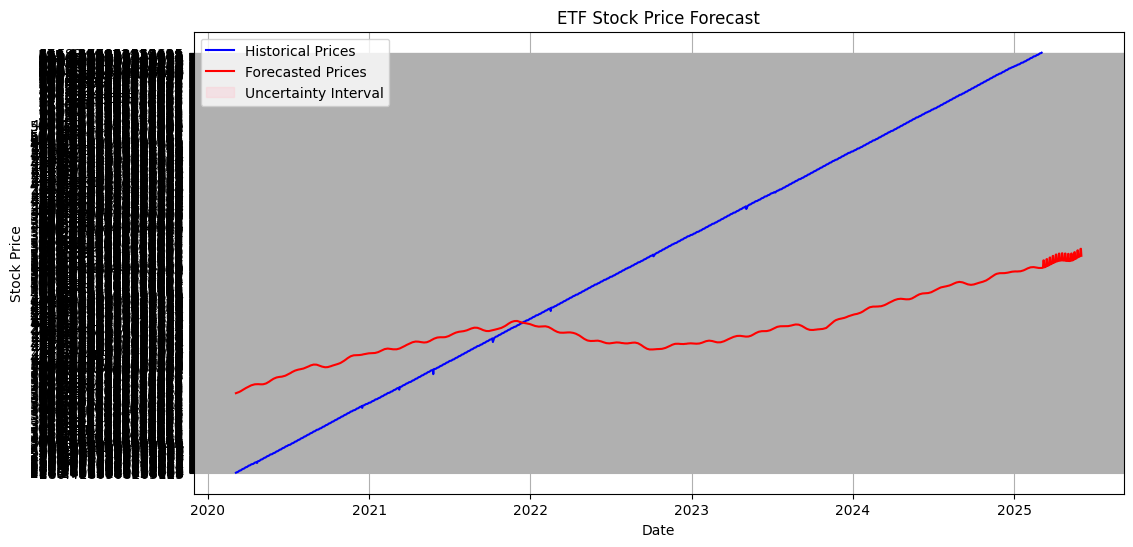

In [11]:
# Load historical stock data
data = pd.read_csv("etf_data.csv")

# Rename columns for Prophet
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
data["ds"] = pd.to_datetime(data["ds"])  # Convert Date to datetime format

# Ensure there are no missing values
data.dropna(inplace=True)

# Train Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(data)

# Create future dataframe (90 days ahead)
future = model.make_future_dataframe(periods=90)  # Generate future dates
forecast = model.predict(future)  # Generate forecasts

# ✅ Check if forecast was created successfully
print(forecast.head())  # This should print forecasted values

# Custom visualization: Historical prices, forecasted prices, and uncertainty intervals
plt.figure(figsize=(12,6))
plt.plot(data["ds"], data["y"], label="Historical Prices", color="blue")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecasted Prices", color="red")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"],
                 color="pink", alpha=0.3, label="Uncertainty Interval")
plt.title("ETF Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

**Download the dataset and trained model**

In [ ]:
from google.colab import files  # For Google Colab users

# Download dataset
files.download("etf_data.csv")

# Download trained model
files.download("prophet_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Download the trained model in json**

In [ ]:
import json

# JSON content
data = {
    "ETC_Analysis_Task": {
        "Problem": "When investing in Exchange-Traded Funds (ETFs), it’s important to know when to buy and sell to maximize profits. Many traders rely on past trends or intuition, but using data-driven methods like moving averages and forecasting can lead to better decision-making.",
        "Objectives": {
            "1": "Understand Past Trends – Collect 5+ years of ETF stock data using PySpark and yfinance.",
            "2": "Find Buy/Sell Signals – Calculate 10-day and 100-day moving averages to spot the best times to buy or sell.",
            "3": "Visualize the Market – Create graphs to see how prices change over time and where trading opportunities exist.",
            "4": "Check If the Strategy Works – Count buy and sell signals and evaluate their effectiveness.",
            "5": "Predict Future Prices – Use Prophet to forecast ETF prices for the next 90 days to help traders plan ahead."
        },
        "Goal": "Use data analysis to give traders clear insights and help them make smarter ETF investment decisions."
    }
}

# Save as JSON file
with open("etc_analysis.json", "w") as json_file:
    json.dump(data, json_file, indent=4)

print("✅ JSON file 'etc_analysis.json' has been created successfully!")

✅ JSON file 'etc_analysis.json' has been created successfully!


**References**

NUIG Dr. Umair ul Hassan - Lecture Slides MS5114 2024-2025
NUI Galway Library, Harvard Referencing Guidelines: http://libguides.library.nuigalway.ie/c.php?g=543943&p=4591416
yfinance Documentation: https://pypi.org/project/yfinance/

I have read the University’s code of practice on plagiarism/University’s Academic Integrity policy QA220. I know that plagiarism is wrong. I hereby certify this material, which I submit for assessment on the programme of study leading to the award of MSc degree, is entirely my own work. It has not been taken from the work of others, except to the extent that such work has been cited and acknowledged within the text of my work. All materials used are paraphrased appropriately or enclosed by quotation marks. I also recognise that collusion is wrong. I have not allowed and will not allow anyone to copy my work with the intention of passing it off as their own. I also acknowledge that copying someone else’s assignment (or part of it) is wrong and declare that my assignments are entirely my own work.

Student ID Number: 24259938
Name: Jacky Kumar
Signature: Jacky Kumar
Date: 05/03/2025